# 

title: Regression and KMeans Modeling Analysis author: - name: Caroline
O’Sullivan affiliations: - id: bu name: Boston University city: Boston
state: MA - name: Bhargavi Manyala affiliations: - ref: bu - name:
Taylor Luckenbill affiliations: - ref: bu bibliography: bibliography.bib
csl: csl/econometrica.csl format: html: toc: true number-sections: true
df-print: paged engine: jupyter jupyter: python3 execute: echo: true
eval: true output: true freeze: auto —

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt



spark = SparkSession.builder \
    .appName("JobPostingsAnalysis") \
    .getOrCreate()

file_path = "data/lightcast_job_postings.csv"

df_c = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(file_path)
df_c.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/10/09 22:03:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/10/09 22:03:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+

In [2]:
from pyspark.sql.functions import regexp_replace, trim, col, split, explode

df_clean = df_c.withColumn(
    "SPECIALIZED_SKILLS_NAME",
    regexp_replace(col("SPECIALIZED_SKILLS_NAME"), r"[\[\]\n\"]", "")
)


In [3]:
import numpy as np
from pyspark.sql.functions import expr, col, when

# Calculate overall median salary
overall_median_salary = df_clean.approxQuantile("SALARY", [0.5], 0.01)[0]

# Median by employment type
median_by_employment_type = df_clean.groupBy("EMPLOYMENT_TYPE") \
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))

# Median by employment type name
median_by_employment_type_name = df_clean.groupBy("EMPLOYMENT_TYPE_NAME") \
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))

# Join and fill missing salaries
df_clean = df_clean.join(
    median_by_employment_type_name,
    on="EMPLOYMENT_TYPE_NAME",
    how="left"
).withColumn(
    "SALARY",
    when(col("SALARY").isNotNull(), col("SALARY"))
    .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
    .otherwise(overall_median_salary)
).drop("median_salary_emp_type_name")
df_selected = df_clean.select("SALARY", "NAICS_2022_2_NAME", "SPECIALIZED_SKILLS_NAME")
df_selected.dropna()

DataFrame[SALARY: double, NAICS_2022_2_NAME: string, SPECIALIZED_SKILLS_NAME: string]

In [ ]:
from pyspark.sql.functions import when, lower, sum, avg, col, split, trim, lower, size, array_intersect, array
from pyspark.sql.types import IntegerType


ai_skills = [
    "machine learning", "artificial intelligence", "deep learning", "data science",
    "neural networks", "computer vision", "natural language processing",
    "nlp", "ai", "automation", "predictive analytics", "data mining",
    "tensorflow", "pytorch", "data engineering", "big data"
]

# Create a column as an array of skills
df_array = df_selected.withColumn(
    "skills_array",
    split(lower(col("SPECIALIZED_SKILLS_NAME")), ",")
)

# Trim whitespace from array elements
from pyspark.sql.functions import expr
df_array = df_array.withColumn(
    "skills_array",
    expr("transform(skills_array, x -> trim(x))")
)

# Define AI skills as a Spark array
ai_skills_spark = array(*[expr(f"'{s}'") for s in ai_skills])

# Count AI skills using array_intersect
df_features = df_array.withColumn(
    "AI_skill_count",
    size(array_intersect(col("skills_array"), ai_skills_spark))
)

df_industry = df_features.groupBy("NAICS_2022_2_NAME").agg(
    avg("AI_skill_count").alias("avg_ai_skills"),
    expr("percentile_approx(SALARY, 0.5)").alias("median_salary")
)
df_industry = df_industry.dropna(subset=["NAICS_2022_2_NAME"])
df_industry.orderBy(col("avg_ai_skills").desc()).show(10, truncate=False)


+---------------------------------------------+-------------------+-------------+
|NAICS_2022_2_NAME                            |avg_ai_skills      |median_salary|
+---------------------------------------------+-------------------+-------------+
|Transportation and Warehousing               |0.6951219512195121 |116500.0     |
|Real Estate and Rental and Leasing           |0.6722689075630253 |116500.0     |
|Manufacturing                                |0.6488502175264139 |116500.0     |
|Information                                  |0.6203680362994707 |116500.0     |
|Mining, Quarrying, and Oil and Gas Extraction|0.6011904761904762 |116500.0     |
|Finance and Insurance                        |0.5863524925088531 |116500.0     |
|Management of Companies and Enterprises      |0.5793357933579336 |116500.0     |
|Retail Trade                                 |0.4976958525345622 |116500.0     |
|Utilities                                    |0.49117647058823527|116500.0     |
|Health Care and

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Index industry
indexer = StringIndexer(inputCol="NAICS_2022_2_NAME", outputCol="industry_idx")
df_indexed = indexer.fit(df_industry).transform(df_industry)

# One-hot encode
encoder = OneHotEncoder(inputCol="industry_idx", outputCol="industry_vec")
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Assemble features
assembler = VectorAssembler(
    inputCols=["avg_ai_skills", "median_salary", "industry_vec"],
    outputCol="features"
)
df_features_final = assembler.transform(df_encoded)
df_features_final.select("features").show(5, truncate=False)



+------------------------------------------------+
|features                                        |
+------------------------------------------------+
|(22,[0,1,3],[0.2765414928140936,116500.0,1.0])  |
|(22,[0,1,16],[0.35360824742268043,87216.0,1.0]) |
|(22,[0,1,17],[0.6722689075630253,116500.0,1.0]) |
|(22,[0,1,10],[0.6203680362994707,116500.0,1.0]) |
|(22,[0,1,20],[0.32166947723440137,116500.0,1.0])|
+------------------------------------------------+
only showing top 5 rows



In [6]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# 1. Initialize KMeans
kmeans = KMeans(featuresCol="features", k=5, seed=42)  # choose k as desired

# 2. Fit model
model = kmeans.fit(df_features_final)

# 3. Make predictions
predictions = model.transform(df_features_final)

# 4. Evaluate clustering (optional)
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score: {silhouette}")

# 5. Inspect cluster centers
centers = model.clusterCenters()
print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# 6. Show cluster assignments
predictions.select("NAICS_2022_2_NAME", "avg_ai_skills", "median_salary", "prediction").show(10, truncate=False)

Silhouette score: 0.8571427451623391
Cluster Centers:
Cluster 0: [4.67534910e-01 1.16500000e+05 5.55555556e-02 5.55555556e-02
 5.55555556e-02 0.00000000e+00 5.55555556e-02 0.00000000e+00
 5.55555556e-02 5.55555556e-02 5.55555556e-02 5.55555556e-02
 5.55555556e-02 5.55555556e-02 5.55555556e-02 5.55555556e-02
 0.00000000e+00 5.55555556e-02 5.55555556e-02 5.55555556e-02
 5.55555556e-02 5.55555556e-02]
Cluster 1: [3.53608247e-01 8.72160000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Cluster 2: [4.28143713e-01 1.07500000e+05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

+------------------------------------------------------------------------+-------------------+-------------+----------+
|NAICS_2022_2_NAME                                                       |avg_ai_skills      |median_salary|prediction|
+------------------------------------------------------------------------+-------------------+-------------+----------+
|Administrative and Support and Waste Management and Remediation Services|0.2765414928140936 |116500.0     |0         |
|Public Administration                                                   |0.35360824742268043|87216.0      |1         |
|Real Estate and Rental and Leasing                                      |0.6722689075630253 |116500.0     |0         |
|Information                                                             |0.6203680362994707 |116500.0     |0         |
|Unclassified Industry                                                   |0.32166947723440137|116500.0     |0         |
|Accommodation and Food Services        

In [7]:
from pyspark.sql.functions import avg, count

cluster_summary = predictions.groupBy("prediction", "NAICS_2022_2_NAME").agg(
    avg("avg_ai_skills").alias("avg_ai_skills"),
    avg("median_salary").alias("median_salary"),
    count("*").alias("num_postings")
).orderBy("prediction")

cluster_summary.show(20, truncate=False)


+----------+------------------------------------------------------------------------+-------------------+-------------+------------+
|prediction|NAICS_2022_2_NAME                                                       |avg_ai_skills      |median_salary|num_postings|
+----------+------------------------------------------------------------------------+-------------------+-------------+------------+
|0         |Information                                                             |0.6203680362994707 |116500.0     |1           |
|0         |Real Estate and Rental and Leasing                                      |0.6722689075630253 |116500.0     |1           |
|0         |Finance and Insurance                                                   |0.5863524925088531 |116500.0     |1           |
|0         |Construction                                                            |0.3709677419354839 |116500.0     |1           |
|0         |Utilities                                                

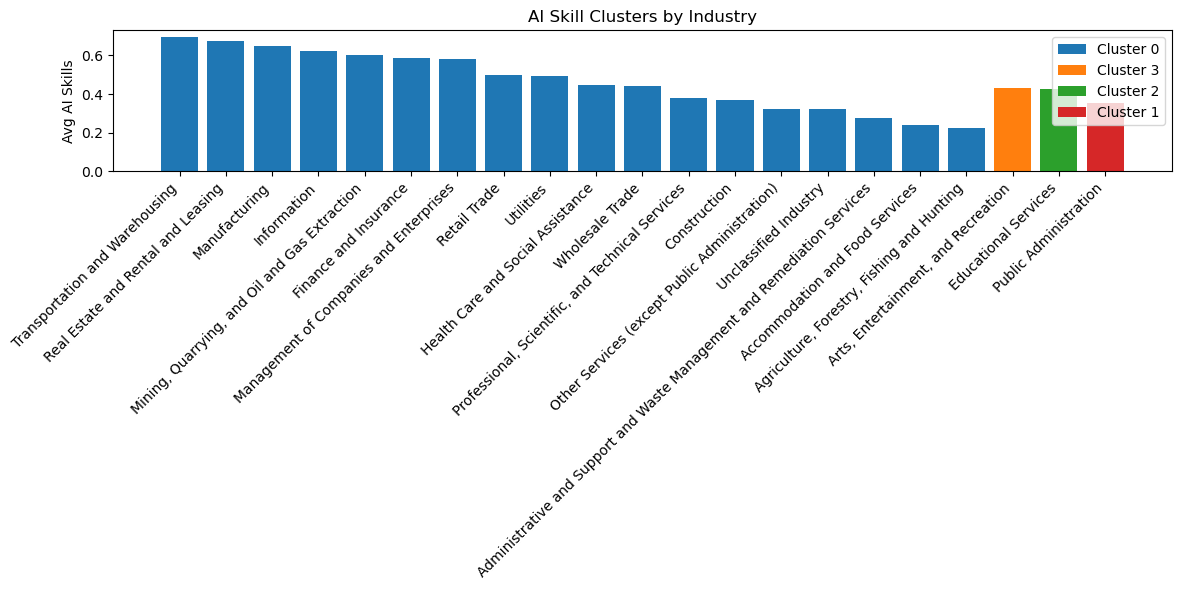

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
cluster_pd = cluster_summary.toPandas()

# Sort by avg_ai_skills
cluster_pd = cluster_pd.sort_values("avg_ai_skills", ascending=False)

plt.figure(figsize=(12,6))
for cluster in cluster_pd['prediction'].unique():
    subset = cluster_pd[cluster_pd['prediction'] == cluster]
    plt.bar(subset['NAICS_2022_2_NAME'], subset['avg_ai_skills'], label=f"Cluster {cluster}")

# Rotate x-axis labels 45 degrees and align right
plt.xticks(rotation=45, ha='right')
plt.ylabel("Avg AI Skills")
plt.title("AI Skill Clusters by Industry")
plt.legend()
plt.tight_layout()  # Ensure labels fit nicely
plt.show()

